In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

import training
from training import load_config, generate_dataloader, get_model, train_loop, cal_MeanIoU_score
from utils.preprocessing import load_image, apply_img_preprocessing

from inference import load_saved_model, pred_segmentation_mask

# Training

In [3]:
config_path = "./configs/unet.yaml"
config = load_config(config_path)
pprint(config)

{'dataset_loc': {'train': {'img_dir': '/cs6945share/retro_project/bdd100k/images/train',
                           'mask_dir': '/cs6945share/retro_project/bdd100k/generated_masks_v0_1/train'},
                 'val': {'img_dir': '/cs6945share/retro_project/bdd100k/images/val',
                         'mask_dir': '/cs6945share/retro_project/bdd100k/generated_masks_v0_1/val'}},
 'dataset_preprocessing': {'RGB_labelmap': 'configs/kaggle_road_seg.json',
                           'RGB_mask': False,
                           'num_classes': 2,
                           'one_hot_mask': False,
                           'resize_height': 720,
                           'resize_width': 1280},
 'enable_cuda': True,
 'inference': {'foreground_threshold': 0.5},
 'model': {'in_channels': 3, 'out_channels': 1},
 'results_loc': 'experiment_results/',
 'training': {'batch_size': 1,
              'learning_rate': 0.05,
              'num_epochs': 10,
              'num_workers': 2,
              're

In [4]:
# copy paste config here to edit and experiment
config = {
    'dataset_loc': {'train': {'img_dir': 'data/archive/train/images',
                           'mask_dir': 'data/archive/train/masks'},
                 'val': {'img_dir': 'data/archive/valid/images',
                         'mask_dir': 'data/archive/valid/masks'}},
    
 'dataset_preprocessing': {'RGB_labelmap': 'configs/kaggle_road_seg.json',
                           'RGB_mask': True,
                           'num_classes': 2,
                           'one_hot_mask': False,
                           'resize_height': 360,
                           'resize_width': 640},
 'enable_cuda': True,
 'inference': {'foreground_threshold': 0.5},   
 'model': {
     'in_channels': 3, 'out_channels': 1
 },
 'results_loc': 'experiment_results/',
 'training': {
     'batch_size': 4,
      'learning_rate': 0.05,
      'num_epochs': 5,
      'num_workers': 2,
      'resume_checkpoint': None,
      'save_checkpoint_freq': 5
 }
}

In [5]:
# get required config parameters
model_config = config["model"]
train_config = config["training"]
dataset_config = config["dataset_loc"]
preprocess_config = config["dataset_preprocessing"]

In [6]:
if config["enable_cuda"]:
    training.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using DEVICE: {training.DEVICE}")

Using DEVICE: cuda


In [7]:
# update preprocessing config if required
resize_height, resize_width = preprocess_config["resize_height"], preprocess_config["resize_height"]

# in case one wants to try out different transformations
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((resize_height, resize_width)),   # ensure resize same is used for mask by setting preprocess_config
    transforms.ToTensor()
])

# generate train data loader
train_loader, train_size = generate_dataloader(image_dir=dataset_config["train"]["img_dir"],
                                               mask_dir=dataset_config["train"]["mask_dir"],
                                               preprocess_config=preprocess_config,
                                               batch_size=train_config["batch_size"],
                                               num_workers=train_config["num_workers"], img_transform=None)   # send new transform here if required

# generate validation data loader
val_loader, val_size = generate_dataloader(image_dir=dataset_config["val"]["img_dir"],
                                           mask_dir=dataset_config["val"]["mask_dir"],
                                           preprocess_config=preprocess_config,
                                           batch_size=train_config["batch_size"],
                                           num_workers=train_config["num_workers"], img_transform=None)

print(f"Train Dataset loaded. #samples: {train_size}")
print(f"Validation Dataset loaded. #samples: {val_size}")

Train Dataset loaded. #samples: 299
Validation Dataset loaded. #samples: 74


Image batch shape: torch.Size([4, 3, 360, 640])
mask batch shape: torch.Size([4, 1, 360, 640])


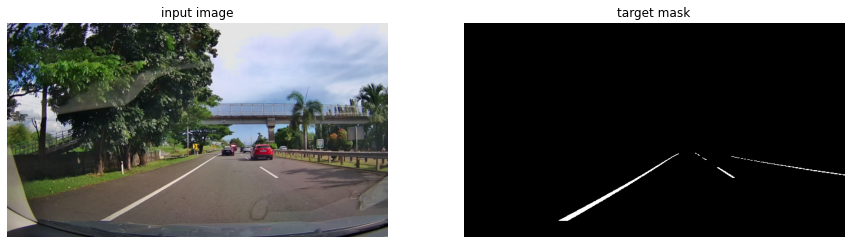

In [8]:
# Ensure that we are getting correct data from data loaders
batch_img, batch_mask = next(iter(train_loader))

print("Image batch shape:", batch_img.shape) 
print("mask batch shape:", batch_mask.shape) 

sample_img = batch_img[0].numpy()   # (c, h, w)
sample_img = sample_img.transpose(1, 2, 0)

sample_mask = batch_mask[0].numpy()   # (c, h, w)
sample_mask = np.squeeze(sample_mask) # (h, w)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].imshow(sample_img)
ax[0].axis("off")
ax[0].set_title("input image")

ax[1].imshow(sample_mask, cmap="gray")
ax[1].axis("off")
ax[1].set_title("target mask")
plt.show()

In [9]:
# Initializing the model, loss function, and the optimizer
model_name = "unet"
model = get_model(model_name, in_channels=model_config['in_channels'], out_channels=model_config['out_channels'])
model = model.to(training.DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=train_config["learning_rate"])

checkpoint_path = train_config["resume_checkpoint"]
if checkpoint_path is not None:
    model.load_state_dict((torch.load(checkpoint_path, weights_only=True)))

In [10]:
# train the model
train_loop(model=model, loss_fn=criterion, optimizer=optimizer,
           train_loader=train_loader, val_loader=val_loader,
           num_epochs=train_config["num_epochs"], save_path=config["results_loc"],
           checkpoint_freq=train_config["save_checkpoint_freq"])

Training Started...


Epoch: 1 train - :   0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 1 val - :   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [1/5], Train Loss: 0.0445, Val Loss: 0.0223, Epoch execution time: 0.85 min


Epoch: 2 train - :   0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 2 val - :   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [2/5], Train Loss: 0.0186, Val Loss: 0.0271, Epoch execution time: 0.82 min


Epoch: 3 train - :   0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 3 val - :   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [3/5], Train Loss: 0.0143, Val Loss: 0.0333, Epoch execution time: 0.83 min


Epoch: 4 train - :   0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 4 val - :   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [4/5], Train Loss: 0.0125, Val Loss: 0.0170, Epoch execution time: 0.82 min


Epoch: 5 train - :   0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 5 val - :   0%|          | 0/19 [00:00<?, ?it/s]

Epoch [5/5], Train Loss: 0.0117, Val Loss: 0.0289, Epoch execution time: 0.78 min
   Learning curve saved to experiment_results/train_log/learning_curve_2025-03-05_01-25-45.png
   Learning history saved to experiment_results/train_log/learning_history_2025-03-05_01-25-45.json
Model saved at: experiment_results/checkpoints/unet_final_2025-03-05_01-25-45.pth
Training Completed! Total time: 4.1099 min


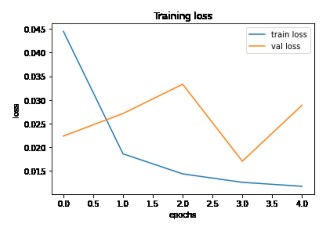

In [11]:
# open saved learning curve
plot_saved_path = "experiment_results/train_log/learning_curve_2025-03-05_01-25-45.png"
img = load_image(plot_saved_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [12]:
# # open saved json history if required
# history_saved_path = "experiment_results/train_log/learning_history_2025-02-28_14-37-53.json"
# with open(history_saved_path, 'r') as json_file:
#     saved_history = json.load(json_file)
# # saved_history

In [13]:
# Evaluate model performance at end of training using mIoU
print("Calculating Mean IoU Score (per class) ...")
train_mIoU = cal_MeanIoU_score(model=model, data_loader=train_loader, num_classes=preprocess_config["num_classes"])
val_mIoU = cal_MeanIoU_score(model=model, data_loader=val_loader, num_classes=preprocess_config["num_classes"])
print("Train mIoU Score:", train_mIoU)
print("Val mIoU Score:", val_mIoU)

Calculating Mean IoU Score (per class) ...
Train mIoU Score: [0.9903948  0.21199411]
Val mIoU Score: [0.9896889  0.17976265]


# Inference

In [8]:
saved_weight_path = "experiment_results/fine_tune_v1/checkpoints/unet_checkpoint_epoch_3.pth"
model_name = "unet"

model_config = {'in_channels': 3, 'out_channels': 1}
inference_config = {'foreground_threshold': 0.5}

In [5]:
# update preprocessing according to training
resize_height, resize_width = 360, 640

# Define the image transformations
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((resize_height, resize_width)),   # ensure resize is same as used during training for loaded model 
    transforms.ToTensor()
])

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using DEVICE: {DEVICE}")

Using DEVICE: cuda


In [9]:
# initialize and load saved model
model = load_saved_model(model_name=model_name, saved_weight_path=saved_weight_path, **model_config)
model = model.to(DEVICE)

Saved weights loaded


In [ ]:
# Test loader
test_loader, test_size = generate_dataloader(image_dir="D:/Ankith B V/Documents/UofU/Datasets/BDD100k/cs6945share/retro_project/bdd100k/images/test",
                                           mask_dir="D:/Ankith B V/Documents/UofU/Datasets/BDD100k/cs6945share/retro_project/bdd100k/images/test",
                                           preprocess_config=preprocess_config,
                                           batch_size=train_config["batch_size"],
                                           num_workers=train_config["num_workers"], img_transform=None)

In [ ]:
# Evaluate model performance at end of training using mIoU
print("Calculating Mean IoU Score (per class) ...")
train_mIoU = cal_MeanIoU_score(model=model, data_loader=train_loader, num_classes=preprocess_config["num_classes"])
val_mIoU = cal_MeanIoU_score(model=model, data_loader=val_loader, num_classes=preprocess_config["num_classes"])
# test_mIoU = cal_MeanIoU_score(model=model, data_loader=test_loader, num_classes=preprocess_config["num_classes"])
print("Train mIoU Score:", train_mIoU)
print("Val mIoU Score:", val_mIoU)

Test image shape: (1600, 2560, 3)


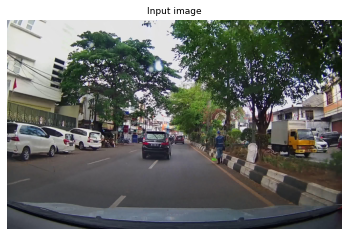

In [25]:
test_img_path = "./data/archive/valid/images/0060_Image12.jpg"
test_img = load_image(test_img_path)
print("Test image shape:", test_img.shape)
plt.imshow(test_img)
plt.axis("off")
plt.title("Input image", fontsize=9)
plt.show()

In [26]:
pred_mask = pred_segmentation_mask(model=model, test_img=test_img, img_transform=img_transform, add_batch_dim=True, device=DEVICE, 
                                   pos_threshold=inference_config["foreground_threshold"])
print("Prediction Shape:", pred_mask.shape)

Prediction Shape: (1, 360, 640)


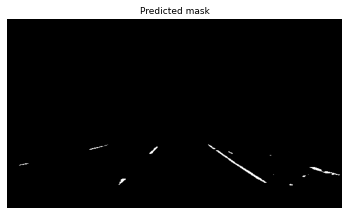

In [27]:
plt.imshow(np.squeeze(pred_mask), cmap="gray")
plt.axis("off")
plt.title("Predicted mask", fontsize=9)
plt.show()